In [ ]:
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
reubensuju_celeb_df_v2_path = kagglehub.dataset_download('reubensuju/celeb-df-v2')
hetb1010_deepfake_path = kagglehub.dataset_download('hetb1010/deepfake')
#harshi112_efficcient_b0_pytorch_default_1_path = kagglehub.model_download('harshi112/efficcient_b0/PyTorch/default/1')

print('Data source import complete.')


Data source import complete.


In [7]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from torchvision import models

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class DeepfakeDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir

        self.image_names = self.data['image_path'].tolist()
        self.labels = self.data['label'].tolist()

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        image_rel_path = self.image_names[idx]

    
        image_rel_path = image_rel_path.replace('\\', os.sep)

        # Extract just the filename to avoid duplicating 'processed_frames'
        if 'processed_frames' in image_rel_path:
            _, filename = os.path.split(image_rel_path)
            image_path = os.path.join(self.root_dir, filename)
        else:
            image_path = os.path.join(self.root_dir, image_rel_path)

        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Missing file: {image_path}")
            
            try:
                direct_path = os.path.join(self.root_dir, image_rel_path.replace('processed_frames\\', ''))
                image = Image.open(direct_path).convert("RGB")
            except FileNotFoundError:
                print(f"Still missing after retry: {direct_path}")
                # Return a black image as placeholder
                placeholder = torch.zeros((3, 224, 224))
                if self.transform:
                    placeholder = self.transform(torch.zeros((224, 224, 3)))
                return placeholder, self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

In [ ]:
# Image transformations
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# The directory where images are stored.
root_directory = '/kaggle/input/deepfake'  

# Load datasets
train_dataset = DeepfakeDataset('/kaggle/input/deepfake/processed_frames/train.csv',
                               root_dir=root_directory,
                               transform=transform)
val_dataset = DeepfakeDataset('/kaggle/input/deepfake/processed_frames/val.csv',
                             root_dir=root_directory,
                             transform=transform)
test_dataset = DeepfakeDataset('/kaggle/input/deepfake/processed_frames/test.csv',
                              root_dir=root_directory,
                              transform=transform)
# The directory where images are stored.
root_directory = '/kaggle/input/deepfake/processed_frames'

# Load datasets with the new root_dir parameter
train_dataset = DeepfakeDataset('/kaggle/input/deepfake/processed_frames/train.csv', root_dir=root_directory, transform=transform)
val_dataset = DeepfakeDataset('/kaggle/input/deepfake/processed_frames/val.csv', root_dir=root_directory, transform=transform)
test_dataset = DeepfakeDataset('/kaggle/input/deepfake/processed_frames/test.csv', root_dir=root_directory, transform=transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import pandas as pd

csv_path = '/kaggle/input/deepfake/processed_frames/train.csv'
df = pd.read_csv(csv_path)

print("First five rows of the CSV:")
print(df.head())


First five rows of the CSV:
                                     image_path  label
0   processed_frames\id34_id33_0008_frame90.jpg      1
1       processed_frames\id39_0009_frame180.jpg      0
2    processed_frames\id0_id9_0008_frame300.jpg      1
3       processed_frames\id36_0008_frame240.jpg      0
4  processed_frames\id22_id20_0006_frame270.jpg      1


In [ ]:
class DeepfakeDetector(nn.Module):
  def __init__(self, hidden_size=128, num_classes=2):
      super(DeepfakeDetector, self).__init__()

      # Load EfficientNet-B0 as the base model
      self.efficient_net = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

      num_features = self.efficient_net.classifier[1].in_features
      self.efficient_net.classifier = nn.Identity()

      # BiLSTM layer
      self.bilstm = nn.LSTM(input_size=num_features,
                           hidden_size=hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)

      # Classification head
      self.fc = nn.Linear(hidden_size * 2, num_classes)

  def forward(self, x):
      batch_size = x.size(0)

      # Pass through EfficientNet
      features = self.efficient_net(x)
      features = features.unsqueeze(1)  # Add sequence dimension

      # Pass through BiLSTM
      lstm_out, _ = self.bilstm(features)
      lstm_out = lstm_out[:, -1, :]  # Use the last hidden state
      # Classification
      out = self.fc(lstm_out)
      return out

In [12]:
# Initialize model, loss function, and optimizer
model = DeepfakeDetector(hidden_size=128, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 33.2MB/s]


In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
  train_accuracies = []
  val_accuracies = []

  for epoch in range(num_epochs):
      model.train()
      train_loss = 0
      correct = 0
      total = 0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

      train_acc = 100. * correct / total
      train_accuracies.append(train_acc)  # Store training accuracy
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

      # Validation
      model.eval()
      val_loss = 0
      correct = 0
      total = 0

      with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)

              val_loss += loss.item()
              _, predicted = outputs.max(1)
              total += labels.size(0)
              correct += predicted.eq(labels).sum().item()

          val_acc = 100. * correct / total
          val_accuracies.append(val_acc)  # Store validation accuracy
          print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_acc:.2f}%")

  return train_accuracies, val_accuracies  # Return the accuracy lists

In [14]:
# Train the model
num_epochs = 15
# Train the model and capture accuracies
train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/15], Loss: 0.2198, Accuracy: 91.49%
Validation Loss: 0.1330, Accuracy: 94.69%
Epoch [2/15], Loss: 0.1251, Accuracy: 95.24%
Validation Loss: 0.0974, Accuracy: 96.51%
Epoch [3/15], Loss: 0.0989, Accuracy: 96.34%
Validation Loss: 0.0964, Accuracy: 96.44%
Epoch [4/15], Loss: 0.0832, Accuracy: 96.89%
Validation Loss: 0.1190, Accuracy: 95.64%
Epoch [5/15], Loss: 0.0682, Accuracy: 97.48%
Validation Loss: 0.0937, Accuracy: 96.76%
Epoch [6/15], Loss: 0.0634, Accuracy: 97.68%
Validation Loss: 0.0934, Accuracy: 96.41%
Epoch [7/15], Loss: 0.0558, Accuracy: 97.93%
Validation Loss: 0.0857, Accuracy: 96.94%
Epoch [8/15], Loss: 0.0491, Accuracy: 98.21%
Validation Loss: 0.0735, Accuracy: 97.41%
Epoch [9/15], Loss: 0.0433, Accuracy: 98.41%
Validation Loss: 0.0667, Accuracy: 97.60%
Epoch [10/15], Loss: 0.0406, Accuracy: 98.56%
Validation Loss: 0.0806, Accuracy: 97.05%
Epoch [11/15], Loss: 0.0385, Accuracy: 98.64%
Validation Loss: 0.0871, Accuracy: 97.39%
Epoch [12/15], Loss: 0.0363, Accuracy: 98


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2479
           1       0.97      1.00      0.98     14696

    accuracy                           0.97     17175
   macro avg       0.97      0.92      0.94     17175
weighted avg       0.97      0.97      0.97     17175



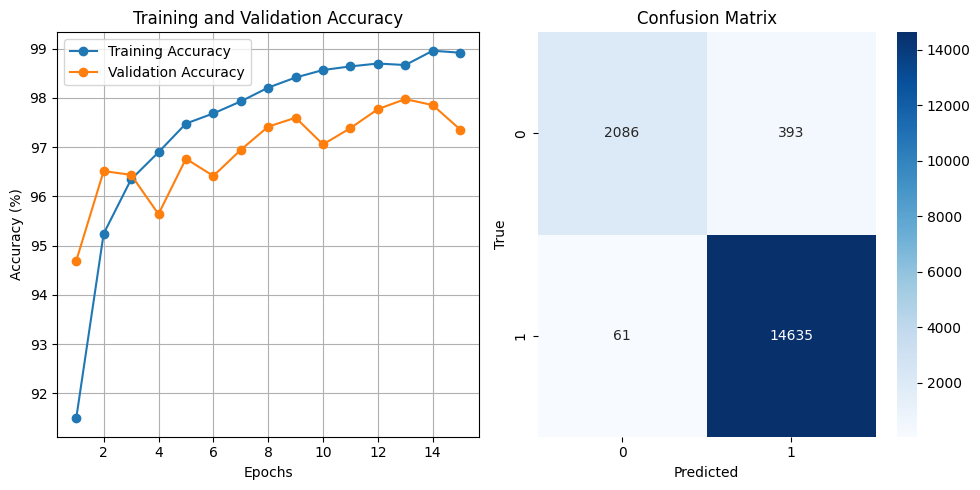

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, val_loader, device, train_accuracies, val_accuracies, num_epochs):
  # Plot training and validation accuracy curves
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
  plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.grid(True)

  # Evaluate model and create confusion matrix
  model.eval()
  y_true = []
  y_pred = []

  with torch.no_grad():
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = outputs.max(1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

  # Print classification report
  print("\nClassification Report:")
  print(classification_report(y_true, y_pred))

  # Plot confusion matrix
  plt.subplot(1, 2, 2)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")

  plt.tight_layout()
  plt.show()

  return y_true, y_pred

# After training, evaluate the model
y_true, y_pred = evaluate_model(model, val_loader, device, train_accuracies, val_accuracies, num_epochs)

In [ ]:
torch.save(model.state_dict(), 'deepfake28.pth')

In [ ]:
import cv2
from PIL import Image
import numpy as np

def process_video_frames(video_path, transform, batch_size=32):
  """
  Process video frames and prepare them for the model
  """
  cap = cv2.VideoCapture(video_path)
  frames = []

  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break

      # Convert BGR to RGB
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      frame_pil = Image.fromarray(frame_rgb)

      # Apply the same transformations used during training
      frame_transformed = transform(frame_pil)
      frames.append(frame_transformed)

      # Process in batches to avoid memory issues
      if len(frames) >= batch_size:
          yield torch.stack(frames).to(device)
          frames = []

  # Process remaining frames
  if frames:
      yield torch.stack(frames).to(device)

  cap.release()

def predict_video(model, video_path, transform):
  """
  Predict if a video is real or fake
  """
  model.eval()
  predictions = []

  with torch.no_grad():
      for batch in process_video_frames(video_path, transform):
          outputs = model(batch)
          _, predicted = outputs.max(1)
          predictions.extend(predicted.cpu().numpy())

  # Calculate the final prediction based on majority voting
  fake_ratio = np.mean(predictions)
  final_prediction = "FAKE" if fake_ratio > 0.5 else "REAL"
  confidence = max(fake_ratio, 1 - fake_ratio) * 100

  return final_prediction, confidence, predictions

def test_video(model, video_path):
  """
  Test a video and display results
  """
  print(f"\nAnalyzing video: {video_path}")
  prediction, confidence, frame_predictions = predict_video(model, video_path, transform)

  print(f"Prediction: {prediction}")
  print(f"Confidence: {confidence:.2f}%")
  print(f"Total frames analyzed: {len(frame_predictions)}")
  print(f"Frames predicted as fake: {sum(frame_predictions)} ({(sum(frame_predictions)/len(frame_predictions))*100:.2f}%)")

  return prediction, confidence, frame_predictions

"""
# Test a single video
video_path = "path/to/your/video.mp4"
result = test_video(model, video_path)
"""

# Function to test multiple videos
def test_multiple_videos(model, video_paths):
  """
  Test multiple videos and display results for each
  """
  results = {}
  for video_path in video_paths:
      prediction, confidence, frame_predictions = test_video(model, video_path)
      results[video_path] = {
          'prediction': prediction,
          'confidence': confidence,
          'frame_predictions': frame_predictions
      }
  return results


#/kaggle/input/celeb-df-v2/YouTube-real/00025.mp4

video_paths = [
  "/kaggle/input/celeb-df-v2/YouTube-real/00010.mp4",
  "/kaggle/input/celeb-df-v2/YouTube-real/00028.mp4",
  "/kaggle/input/celeb-df-v2/Celeb-synthesis/id0_id1_0005.mp4",
  "/kaggle/input/celeb-df-v2/Celeb-synthesis/id0_id28_0009.mp4"

]

results = test_multiple_videos(model, video_paths)


Analyzing video: /kaggle/input/celeb-df-v2/YouTube-real/00010.mp4
Prediction: REAL
Confidence: 99.05%
Total frames analyzed: 422
Frames predicted as fake: 4 (0.95%)

Analyzing video: /kaggle/input/celeb-df-v2/YouTube-real/00028.mp4
Prediction: REAL
Confidence: 94.93%
Total frames analyzed: 473
Frames predicted as fake: 24 (5.07%)

Analyzing video: /kaggle/input/celeb-df-v2/Celeb-synthesis/id0_id1_0005.mp4
Prediction: FAKE
Confidence: 100.00%
Total frames analyzed: 459
Frames predicted as fake: 459 (100.00%)

Analyzing video: /kaggle/input/celeb-df-v2/Celeb-synthesis/id0_id28_0009.mp4
Prediction: FAKE
Confidence: 100.00%
Total frames analyzed: 520
Frames predicted as fake: 520 (100.00%)
